In [1]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup, TrainingArguments, DataCollatorForLanguageModeling
from tqdm import tqdm, trange
import torch.nn.functional as F
import csv
import pickle
import string
import matplotlib.pyplot as plt
import re
from collections import Counter

In [2]:
msg_from_ex = pickle.load(open("/Users/bayesiandater/ex_bot/resources/msg_from_ex", "rb"))
msg_from_ex = [m.lower() for m in msg_from_ex if m.strip() != ""]

In [3]:
rng = np.random.default_rng(713)
train_idx = rng.integers(low=0, high=len(msg_from_ex), size=int(0.8 * len(msg_from_ex)))
valid_idx = [i for i in range(len(msg_from_ex)) if i not in train_idx]
train_ls, valid_ls = np.array(msg_from_ex)[train_idx], np.array(msg_from_ex)[valid_idx]

(array([54., 27., 24., 14.,  3.,  3.,  0.,  1.,  0.,  1.]),
 array([ 1. ,  3.1,  5.2,  7.3,  9.4, 11.5, 13.6, 15.7, 17.8, 19.9, 22. ]),
 <BarContainer object of 10 artists>)

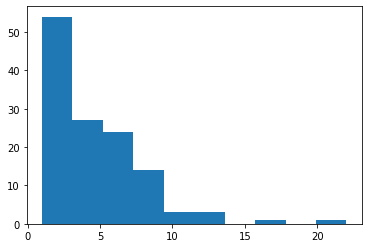

In [4]:
plt.hist([len(m.strip().split()) for m in train_ls])

In [5]:
# get the custom tokens to add to tokenizer
# get the GPT2 token list
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

GPT2_tokens = []
for w in tokenizer.encoder.keys():
    w = w.strip("Ġ").lower()
    GPT2_tokens.append(w)
    
# only add all whole words from both train + valid sets 
# that are not in the original GPT2 tokenizer's vocabulary 15
all_words = []
for m in msg_from_ex:
    m = m.strip(string.punctuation).lower().split()
    all_words += m

added_tokens = []
for word, freq in Counter(all_words).most_common():
    if word not in GPT2_tokens:
        added_tokens.append(word)
        
del tokenizer

In [6]:
added_tokens = ["coz", "noice", "lmaooo", "ooh", "uhh", "prolly", "yesss", "nvm", "ooof", "thingy", '👀',]

In [7]:
class MSG(Dataset):  
    def __init__(self, ls_stc, truncate=False, gpt2_type="gpt2", max_length=1024, added_tokens=None):

        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        special_tokens = {'pad_token':'<|pad|>','sep_token':'<|sep|>'}
        self.tokenizer.add_special_tokens(special_tokens)
        if added_tokens is not None:
            self.tokenizer.add_tokens(added_tokens)
        self.msgs = []
        max_len = 0
        
        for m in ls_stc:
            m = torch.tensor(
                self.tokenizer.encode(self.tokenizer.bos_token + f"{m[:max_length]}" + self.tokenizer.eos_token, \
                                      max_length=15, padding="max_length", truncation=True))
            max_len = max(len(m), max_len)

            self.msgs.append(m)
        
        if truncate:
            self.msgs = self.msgs[:20000]
            
        self.msgs_count = len(self.msgs)
        
    def __len__(self):
        return self.msgs_count

    def __getitem__(self, item):
        return self.msgs[item]
    

In [8]:
ds_custom_train = MSG(train_ls, truncate=True, gpt2_type="gpt2", added_tokens=added_tokens)  
ds_custom_valid = MSG(valid_ls, truncate=True, gpt2_type="gpt2", added_tokens=added_tokens)  


In [9]:
data_collator = DataCollatorForLanguageModeling(
        tokenizer=ds_custom_train.tokenizer,
        mlm=False
    )

In [10]:
training_args = TrainingArguments(
    output_dir="/Users/bayesiandater/ex_bot",          # output directory
    num_train_epochs=6,              # total # of training epochs
    per_device_train_batch_size=10,  # batch size per device during training
    per_device_eval_batch_size=10,   # batch size for evaluation
    warmup_steps=200,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    prediction_loss_only=True,
    save_steps=1000 
)

In [11]:
device= "gpu" if torch.cuda.is_available() else "cpu"

model_custom = GPT2LMHeadModel.from_pretrained('gpt2')
model_custom.resize_token_embeddings(len(ds_custom_train.tokenizer))
model_custom = model_custom.to(device)


In [ ]:
trainer = Trainer(
    model=model_custom,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    data_collator=data_collator,
    train_dataset=ds_custom_train,         # training dataset
    eval_dataset=ds_custom_valid            # evaluation dataset
)

trainer.train()

In [13]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 71
  Batch size = 10


{'eval_loss': 6.732573986053467,
 'eval_runtime': 1.2169,
 'eval_samples_per_second': 58.345,
 'eval_steps_per_second': 6.574,
 'epoch': 6.0}

### 1. beam search

In [18]:
max_length = 50 
num_beams=20
num_return_sequences= 20
early_stopping=True 
no_repeat_ngram_size=2
total = []

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:3].unsqueeze(0), 
                                max_length = max_length,
                               num_beams=num_beams,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love it
i love it yesss
i love this topic
i love this post
i love
i love this comment
i love this topic yesss
i love this post yesss
i love this song yesss
i love this thread yesss
i love this topic nvm
i love yesss
i love this thread
i love this photo yesss
i love this review yesss
i love it nvm
i love this item yesss
i love this story
i love it when you
i love this post nvm
all water yesss
all water
all water nvm
all water nvm
all water yesss
all water yesss yesss
all water yesss nvm
all water yesss water
all water yesss Advertisements
all water nvm water
all watercolor yesss
all watercooling yesss
all water yesss back
all watercooling nvm
all watercolor nvm
all watercolor
all water yesss milk
all water nvm milk
all water yesss other
all watercooling


### 2. sampling 

In [19]:
max_length = 100
num_beams=20
num_return_sequences= 20
early_stopping=True 
no_repeat_ngram_size=2
do_sample = True

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:3].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love it depends on whether it is bought yesss i guess nvm
i love this topic
i love it but they don nvm
i love it now paypal not
i love this post,
i love it! goodbye
i love it
i love it when i live in arabedville
i love this story
i love (this blog)
i love it
i love this post yesss
i love this stuff
i love living yesss bad_bad_night
i love it yesss
i love yesss
i love and dont forget are all
i love this comment
i love, you can download everything i know about
i love this item i am a seasoned traveler
all water yesss your grandmothers nvm
all waterfalls and mountains, mountains, marshes, yesss
all watercolor russian, roman, rustic, frick, granny, speckled, red, golden, tungsten, yellow
all watermelon juice
all watercolor i am
all water yesss
all water yesss
all water
all water
all water nvm Thank you for visiting the My Home page
all watermark=0 color=white color=#000000 color="0" yesss
all water, no matter how low uhh
all watermarks 👀 yesss
all watercolor_daddy_stylesheet
all water ex

In [20]:
max_length = 100
num_beams=20
num_return_sequences= 20
early_stopping=True 
no_repeat_ngram_size=2
do_sample = True

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:3].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                early_stopping=False)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love is sweet and i dont need to be reminded why
i love ooof
i love this song}
i love it.goodbye, its
i love the look of this sweater nvm
i love it yesss joe berry
i love these days when it comes to cute sexy ass yesss pushing aside
i love it
i love yesss.m.
i love it nvm smil
i love it though, i am guessing and they always have been
i lovewatching yesss starry
i love
i love this guy yesss
i love it when you guys can't wait anymore
i love it
i love this post
i love watching
i love it though! tat
i love this posts nvm
all water yesss any liquid
all watertight
all water buffalo
all water is delicious yesss
all water nvm water
all water
all water
all water.
all watermarks noice in, yesss
all water yesss
all water nvm sw nvm
all water
all water yesss 1
all waterfrontmuseum.org
all waterfalls nvm
all watermelons
all watermarks yesss r yesss
all watermark yesss
all water now yesss
all water


In [14]:
max_length = 100
num_beams=10
num_return_sequences= 10
early_stopping=True 
no_repeat_ngram_size=2
do_sample = True
temperature=0.9
top_k = 20
total = []

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:5].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                top_k = top_k,
                                temperature=temperature,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love itIn this ooof
i love itby thingy
i love itThe latest edition of the podcast
i love itA nvm
i love itIt's thingy A little history prolly
i love it prolly thingy ooof The New Orleans Pelicans are thingy the NBA's ooof
i love itby Chris Grayling thingy
i love itThe National ooof thingy When the United States Senate Judiciary Committee prolly
i love itIt is ooof
i love itTheresa May ooof thingy
all water under the table thingy
all water under the sun, rain, shine, night, weeknight, month, year
all water under the sea thingy
all water under the hood
all water under the table
all water under the bed ooof
all water under the moon.
all water under the lamp
all water under the table, you are covered thingy
all water under the moon


In [15]:
max_length = 100
num_beams=10
num_return_sequences= 10
early_stopping=False 
no_repeat_ngram_size=2
do_sample = True
temperature=0.9
top_k = 0
total = []

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:5].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                top_k = top_k,
                                temperature=temperature,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love it" ooof
i love itDigiMonkey Principal 👀 thingy
i love itThis ooof nerves Maharashtra been ooof
i love itFind Out 👀 thingy ooof footballforever16
i love itTo ooof Skinny Love
i love itAbout "Master Naked" thingy pink believe it or not, bro grew up cody sings with j ooof Paris
i love itCheck out the first uhh
i love itThey thingy thingy microsoft php thingy dumbstruck bleakteam
i love itMoscow:
i love itThe Artemis Nikita Lassa spotlighted by TIFF thingy ooh
all water under the bed beans that is the best happy, prep to go
all water under the rainbow
all water under the bed
all water under the maester thingy
all water under the table
all water under the sun 233 thingy
all water under the sun products > volunteer
all water under the sun catch the currents drain
all water under the toilet bowl thingy
all water under the sun thingy


In [16]:
max_length = 100
num_beams=10
num_return_sequences= 10
early_stopping=False
no_repeat_ngram_size=2
do_sample = True
temperature=0.9
top_k = 10
total = []

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:5].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                top_k = top_k,
                                temperature=temperature,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love itThe United States Army ooof
i love it" ooof
i love itThe following is a uhh
i love itThe following is a ooof
i love itImage copyright 👀 thingy The BBC's 👀 i can
i love itThe UESPWiki – Your source for The Elder Scrolls since 1995 thingy prolly The Dragon prolly
i love itA nvm
i love itIn the thingy
i love itThis thingy a i m thingy
i love itThis yesss
all water under the sun
all water under the sun thingy
all water under the table thingy
all water under the sun thingy
all water under the sun
all water under the sun
all water under the sun thingy
all water under the table
all water under the sun. thingy sun,
all water under the table thingy water


In [17]:
max_length = 100
num_beams=10
num_return_sequences= 10
early_stopping=False
no_repeat_ngram_size=2
do_sample = True
temperature=0.5
top_k = 10
total = []

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:5].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                top_k = top_k,
                                temperature=temperature,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love itThe following is a thingy
i love itThe following is a thingy thingy
i love itThe first thingy
i love itThe New York City uhh
i love itThe first yesss
i love itA nvm
i love itThe U.S. ooof
i love itTheresa May ooof thingy The Independent has launched its #FinalSay campaign to noice
i love itThe following is a nvm the first page of the book. thingy
i love itA nvm thingy
all water under the sun
all water under the sun
all water under the sun thingy
all water under the table thingy
all water under the table
all water under the sun thingy
all water under the sun thingy
all water under the sun thingy
all water under the moon
all water under the sun thingy


In [18]:
model_custom

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50270, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [ ]:
trainer.save_model()
ds_custom_train.tokenizer.save_pretrained("/Users/bayesiandater/ex_bot/")

### best results

In [35]:
max_length = 100
num_beams=20
num_return_sequences= 20
early_stopping=False 
no_repeat_ngram_size=2
do_sample = True
total = []

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:3].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                early_stopping=False)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            # print(o)
            total.append(o)
            

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

In [36]:
with open("/Users/bayesiandater/ex_bot/resources/sample_sentences2.txt", "w") as f:
    for line in total:
        f.write(line + "\n")

In [31]:
with open("/Users/bayesiandater/ex_bot/resources/sample_sentences.txt", "w") as f:
    for line in total:
        f.write(line + "\n")